# Some work with the COVID-19 dataset from [Johns Hopkins](https://github.com/CSSEGISandData/COVID-19)

### In this first set of work, I zoom in on observations from the State of Ohio so that I can demonstrate how to make a chart of the top 10 most "infected" counties and then add text to the chart with additional information.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
df = pd.read_csv('./data/time_series_covid19_confirmed_US.csv')
df.head()

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,3/21/2020,3/22/2020,3/23/2020,3/24/2020,3/25/2020,3/26/2020,3/27/2020,3/28/2020,3/29/2020,3/30/2020
0,16,AS,ASM,16,60.0,NaN,American Samoa,US,-14.2710,-170.1320,...,0,0,0,0,0,0,0,0,0,0
1,316,GU,GUM,316,66.0,NaN,Guam,US,13.4443,144.7937,...,15,27,29,32,37,45,51,55,56,58
2,580,MP,MNP,580,69.0,NaN,Northern Mariana Islands,US,15.0979,145.6739,...,0,0,0,0,0,0,0,0,0,0
3,630,PR,PRI,630,72.0,NaN,Puerto Rico,US,18.2208,-66.5901,...,21,23,31,39,51,64,79,100,127,174
4,850,VI,VIR,850,78.0,NaN,Virgin Islands,US,18.3358,-64.8963,...,6,6,7,17,17,17,19,22,0,0


In [33]:
cols = [i for i, v in enumerate(df.columns) if v in ['Admin2', 'Province_State'] or v.endswith('2020')]
df_ohio = df[df.Province_State=='Ohio'].iloc[:,cols].copy()
df_ohio['county'] = df_ohio.Admin2 + ', ' + df_ohio.Province_State  # combine county and State together in a field
df_ohio = df_ohio.drop(columns=['Admin2', 'Province_State']).set_index('county')

# the counts accumulate over time, so the last date column is the total count to-date
df_ohio['3/30/2020'].sort_values().tail(10)  

county
Stark, Ohio        44
Miami, Ohio        46
Medina, Ohio       48
Lorain, Ohio       78
Hamilton, Ohio    101
Lucas, Ohio       114
Mahoning, Ohio    117
Summit, Ohio      118
Franklin, Ohio    281
Cuyahoga, Ohio    493
Name: 3/30/2020, dtype: int64

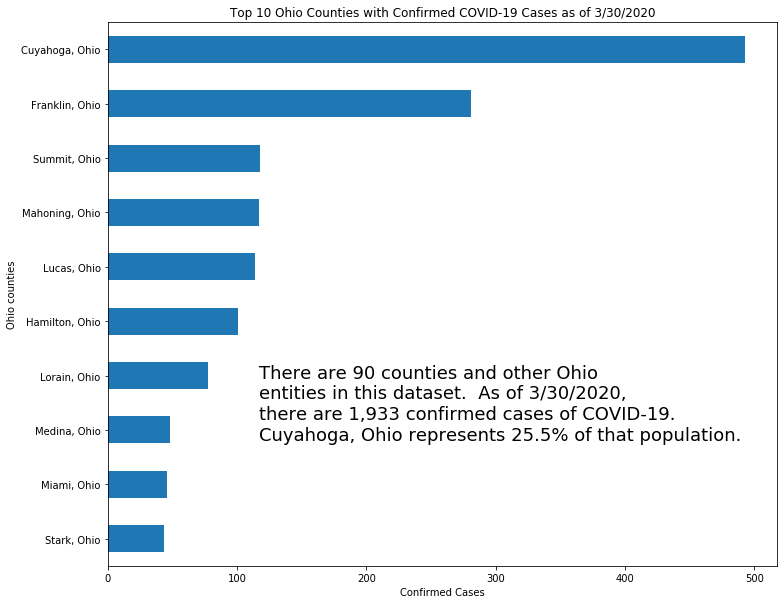

In [62]:
fig, ax = plt.subplots(figsize=(12,10))
title = 'Top 10 Ohio Counties with Confirmed COVID-19 Cases as of ' + df.columns[-1]
worst_county, worst_co_cases = [(k, v) for k, v in df_ohio['3/30/2020'].sort_values().tail(1).items()][0]

inset = """
There are {0} counties and other Ohio 
entities in this dataset.  As of {1}, 
there are {2:,} confirmed cases of COVID-19.  
{3} represents {4:.1f}% of that population.
""".format(df_ohio.shape[0], df.columns[-1], df_ohio['3/30/2020'].sum(), worst_county, 
           (worst_co_cases/df_ohio['3/30/2020'].sum())*100)

_ = df_ohio['3/30/2020'].sort_values().tail(10).plot(kind='barh', ax=ax, title=title)
_ = ax.set_ylabel('Ohio counties')
_ = ax.set_xlabel('Confirmed Cases')

# you have to experiment a little with the x, y positioning to get your word inset positioned just right
text = fig.text(0.30, 0.35, inset, va='center', ha='left', size=18)

<hr style="border-top: 5px solid purple; margin-top: 1px; margin-bottom: 1px"></hr>

### In this second set of work, I revive my Ohio dataframe and show how I can calculate the moving average of infection rates by county.

In [128]:
df_ohio.head()

,1/22/2020,1/23/2020,1/24/2020,1/25/2020,1/26/2020,1/27/2020,1/28/2020,1/29/2020,1/30/2020,1/31/2020,...,3/21/2020,3/22/2020,3/23/2020,3/24/2020,3/25/2020,3/26/2020,3/27/2020,3/28/2020,3/29/2020,3/30/2020
county,,,,,,,,,,,,,,,,,,,,,
"Adams, Ohio",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"Allen, Ohio",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,4,4
"Ashland, Ohio",0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,3,3,2,2
"Ashtabula, Ohio",0,0,0,0,0,0,0,0,0,0,...,1,2,3,3,3,3,5,6,6,6
"Athens, Ohio",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,2,3,3


### Before I can use pandas to calculate moving averages, I must first ["tidy"](https://cran.r-project.org/web/packages/tidyr/vignettes/tidy-data.html) the data.

In [89]:
date_cols = df_ohio.columns.tolist()
rename_cols = {'variable': 'obs_date', 'value': 'confirmed_cases'}

df_ohio_tidy = pd.melt(df_ohio.reset_index(), id_vars=['county'], value_vars=date_cols).rename(columns=rename_cols)
df_ohio_tidy['obs_date'] = pd.to_datetime(df_ohio_tidy.obs_date)

df_ohio_tidy = df_ohio_tidy.set_index('obs_date')
df_ohio_tidy

,county,confirmed_cases
obs_date,,
2020-01-22,"Adams, Ohio",0
2020-01-22,"Allen, Ohio",0
2020-01-22,"Ashland, Ohio",0
2020-01-22,"Ashtabula, Ohio",0
2020-01-22,"Athens, Ohio",0
...,...,...
2020-03-30,"Williams, Ohio",0
2020-03-30,"Wood, Ohio",13
2020-03-30,"Wyandot, Ohio",1


### When I do use moving averages, I usually only use them in charts like below:

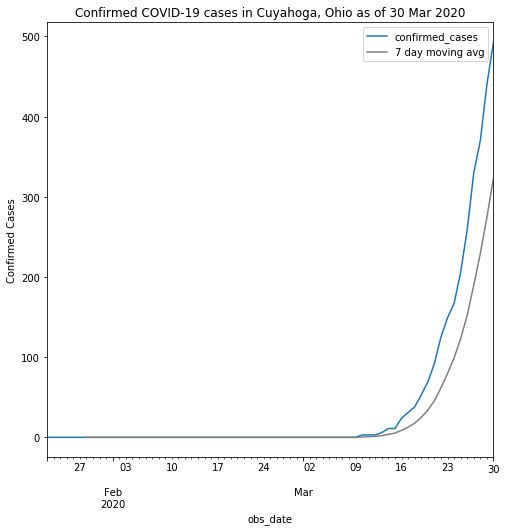

In [127]:
fig, ax = plt.subplots(figsize=(8,8))
rename_col = {'confirmed_cases': '7 day moving avg'}
title = 'Confirmed COVID-19 cases in Cuyahoga, Ohio as of {0:%d %b %Y}'.format(df_ohio_tidy.index.max())

_ = df_ohio_tidy[df_ohio_tidy.county=='Cuyahoga, Ohio'][['confirmed_cases']].plot(ax=ax, title=title)
_ = df_ohio_tidy[df_ohio_tidy.county=='Cuyahoga, Ohio'][['confirmed_cases']].rolling(7).mean().\
    rename(columns=rename_col).plot(ax=ax, color='gray')

_ = ax.set_ylabel('Confirmed Cases')

In [94]:
df_ohio_tidy[df_ohio_tidy.county=='Cuyahoga, Ohio'][['confirmed_cases']].rolling(7).mean()

,confirmed_cases
obs_date,
2020-01-22,NaN
2020-01-23,NaN
2020-01-24,NaN
2020-01-25,NaN
2020-01-26,NaN
...,...
2020-03-26,152.428571
2020-03-27,189.714286
2020-03-28,229.428571


### However, you may have a need to also write the moving averages back to your dataframe.  Here's a way you can calculate the moving averages, by county, and write them back to the dataframe for later analysis.

In [115]:
# https://stackoverflow.com/questions/53339021/python-pandas-calculate-moving-average-within-group
df_ohio_tidy['7ma'] = df_ohio_tidy.groupby('county').confirmed_cases.transform(lambda c: c.rolling(7).mean())

# now, do some spot checking that the moving average calculation resets from county to county
# see how the values change from Crawford County to Cuyahoga County?
df_ohio_tidy.sort_values(['county', 'obs_date']).iloc[1170:1190,:]

,county,confirmed_cases,7ma
obs_date,,,
2020-03-28,"Crawford, Ohio",2,0.857143
2020-03-29,"Crawford, Ohio",2,1.142857
2020-03-30,"Crawford, Ohio",5,1.857143
2020-01-22,"Cuyahoga, Ohio",0,NaN
2020-01-23,"Cuyahoga, Ohio",0,NaN
2020-01-24,"Cuyahoga, Ohio",0,NaN
2020-01-25,"Cuyahoga, Ohio",0,NaN
2020-01-26,"Cuyahoga, Ohio",0,NaN
2020-01-27,"Cuyahoga, Ohio",0,NaN


In [119]:
# more spot checking: see how the values change from Cuyahoga County to Darke County?
df_ohio_tidy.sort_values(['county', 'obs_date']).iloc[1235:1250,:]

,county,confirmed_cases,7ma
obs_date,,,
2020-03-24,"Cuyahoga, Ohio",167,99.000000
2020-03-25,"Cuyahoga, Ohio",206,123.000000
2020-03-26,"Cuyahoga, Ohio",259,152.428571
2020-03-27,"Cuyahoga, Ohio",330,189.714286
2020-03-28,"Cuyahoga, Ohio",370,229.428571
2020-03-29,"Cuyahoga, Ohio",440,274.428571
2020-03-30,"Cuyahoga, Ohio",493,323.571429
2020-01-22,"Darke, Ohio",0,NaN
2020-01-23,"Darke, Ohio",0,NaN
